In [ ]:
!pip install gymnasium numpy pandas matplotlib torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu --force-reinstall --upgrade

In [1]:
# 📌 Cell 1: Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import os


In [3]:
# 📌 Cell 2: Normalization and Simulation Constants

# Simulation constants from Project3.ipynb (Used in SimpleMECEnv)
N_NODES = 10  # Must match SimpleMECEnv initialization
NODE_MIPS_CAPACITY = 500.0
TASK_SIZE_MI = 100.0
ENERGY_RATE_PER_UTIL = 0.75
BASE_COST_PER_STEP = 5.0

# Manual Normalization Constants (for reward calculation)
MAX_UTIL = 1.0
MAX_LAT = 100.0  # Increased from Project3's small internal max (50.0)
MAX_ENERGY = N_NODES * 1.0 * ENERGY_RATE_PER_UTIL + 1e-6 # Max possible energy
MAX_COST = BASE_COST_PER_STEP * N_NODES + 5.0 + 1e-6 # Max possible cost


In [4]:
# 📌 Cell 3: QNetwork and DDQN Agent Module

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    
    def forward(self, x):
        return self.fc(x)


class DDQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=0.001, batch_size=64, memory_size=10000, tau=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.tau = tau

        self.q_net = QNetwork(state_dim, action_dim)
        self.target_net = QNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        self.update_target_net()

    def update_target_net(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

    def act(self, state, epsilon=0.1):
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        
        # The input state needs to be converted to a tensor and unsqueezed for the batch dimension
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        
        # Ensure the model is in evaluation mode for prediction (no grad)
        self.q_net.eval()
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        self.q_net.train() # Switch back to training mode
        
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # current Q values
        q_values = self.q_net(states).gather(1, actions)

        # DDQN target
        # Use q_net to select the next action (Double DQN logic)
        next_actions = self.q_net(next_states).argmax(1, keepdim=True)
        # Use target_net to evaluate the selected next action
        next_q = self.target_net(next_states).gather(1, next_actions)
        
        target = rewards + (1 - dones) * self.gamma * next_q

        loss = nn.MSELoss()(q_values, target.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update target net
        for target_param, param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
            
    def save_model(self, path):
        torch.save(self.q_net.state_dict(), path)
        
    def load_model(self, path):
        self.q_net.load_state_dict(torch.load(path))
        self.update_target_net()


In [5]:
# 📌 Cell 4: Feature Calculation Function

def calculate_metrics(snapshot, allocated_node, MIPS_capacity, n_nodes, task_size_mi, energy_rate_per_util, base_cost_per_step):
    # Metrics from SimpleMECEnv
    cpu_util = snapshot[:, 0]
    mem_util = snapshot[:, 1]
    queue_len_norm = snapshot[:, 3]

    # --- Feature Calculations (from Project3.ipynb) ---
    
    # Utilization
    utilization = (np.mean(cpu_util) + np.mean(mem_util)) / 2.0

    # Latency
    max_queue_len_norm = np.max(queue_len_norm)
    latency = max_queue_len_norm * 5.0

    # Energy
    # In SimpleMECEnv, snapshot[:, 4] is Power_Cons (proxy based on util)
    total_power_norm = np.sum(snapshot[:, 4])
    energy = total_power_norm * energy_rate_per_util

    # Cost
    cost = base_cost_per_step * n_nodes + (np.mean(cpu_util) * 0.5 + np.mean(mem_util) * 0.5) * 5.0

    # Makespan
    # Denominator: Effective MIPS capacity remaining on the allocated node
    denom = max(1e-3, MIPS_capacity[allocated_node] * (1.0 - cpu_util[allocated_node]))
    makespan = task_size_mi / denom

    # Throughput
    throughput = 1.0 / (1.0 + max_queue_len_norm * 10.0)

    return {
        'utilization': float(utilization),
        'latency': float(latency),
        'energy': float(energy),
        'cost': float(cost),
        'makespan': float(makespan),
        'throughput': float(throughput)
    }


In [6]:
# 📌 Cell 5: SimpleMECEnv Module (Updated step function)

class SimpleMECEnv(gym.Env):
    def __init__(self, N=N_NODES):
        super().__init__()
        self.N = N
        # State is a flat vector: task_sizes (N) + channel_gains (N)
        self.state_dim = N * 2  
        self.action_dim = N     # Action is selecting one user to offload (0 to N-1)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.state_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(N) 
        
        # Internal state/metrics representation to align with calculation
        self.internal_state_dim = (N, 5) # (Nodes, [CPU_Util, Mem_Util, BW_Util, Queue_Len, Power_Cons])
        self.internal_snapshot = self._generate_random_snapshot()

        # Simulation constants
        self.MIPS_capacity = np.ones(N) * NODE_MIPS_CAPACITY

    def _generate_random_snapshot(self):
        # Metrics: [CPU_Util, Mem_Util, BW_Util, Queue_Len (norm), Power_Cons]
        snapshot = np.zeros(self.internal_state_dim)
        # Util, Mem, BW
        snapshot[:, 0:3] = np.clip(np.random.normal(loc=0.5, scale=0.2, size=(self.N, 3)), 0, 1)
        # Queue_Len (normalized, 0-1)
        snapshot[:, 3] = np.random.randint(0, 10, size=self.N) / 10.0
        # Power_Cons (proxy based on util)
        snapshot[:, 4] = snapshot[:, 0] * 0.4 + snapshot[:, 1] * 0.6
        return snapshot

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.internal_snapshot = self._generate_random_snapshot()
        
        # Map internal state to flat observation space (for QNetwork)
        task_sizes = np.random.rand(self.N)
        channel_gains = np.random.rand(self.N)
        state = np.concatenate([task_sizes, channel_gains]).astype(np.float32)
        
        return state, {}

    def step(self, action):
        # 1. Update internal snapshot based on the action (allocated_node)
        new_snapshot = self._generate_random_snapshot()
        # Allocation increases CPU util and queue on chosen node (simplified simulation)
        new_snapshot[action, 0] = min(1.0, new_snapshot[action, 0] + 0.12)
        new_snapshot[action, 3] = min(1.0, new_snapshot[action, 3] + 0.25)
        self.internal_snapshot = new_snapshot

        # 2. Calculate metrics using the external function (new logic)
        metrics = calculate_metrics(
            self.internal_snapshot, action, 
            self.MIPS_capacity, self.N, TASK_SIZE_MI, 
            ENERGY_RATE_PER_UTIL, BASE_COST_PER_STEP
        )
        
        # 3. Apply normalization and calculate reward
        util_norm = np.clip(metrics['utilization'] / MAX_UTIL, 0.0, 1.0)
        lat_norm = np.clip(metrics['latency'] / MAX_LAT, 0.0, 1.0)
        energy_norm = np.clip(metrics['energy'] / MAX_ENERGY, 0.0, 1.0)
        cost_norm = np.clip(metrics['cost'] / MAX_COST, 0.0, 1.0)

        # Reward formula from Project3.ipynb
        reward = (1.0 * util_norm) - (0.6 * lat_norm) - (0.25 * energy_norm) - (0.15 * cost_norm)
        reward = float(np.clip(reward, -2.0, 2.0))

        # 4. Generate next observation space state (flat vector for QNetwork)
        # Note: In the original base_model1.ipynb, the new_state was generated by a call to reset, 
        # which makes the MDP not fully Markovian, but we retain the structure for consistency with the base model logic.
        next_state, _ = self.reset() 
        done = False
        
        return next_state, reward, done, False, metrics


In [7]:
# 📌 Cell 6: Initialization Cell
env = SimpleMECEnv(N=N_NODES)
agent = DDQNAgent(env.state_dim, env.action_dim)
MODEL_PATH = 'base_model_trained.pth' # PyTorch standard suffix


In [8]:
# 📌 Cell 7: Training Cell
episodes = 200
steps_per_episode = 50
all_metrics = []
print("Starting Training...")

for ep in range(episodes):
    state, _ = env.reset()
    ep_metrics = {"reward":0, "makespan":0, "energy":0, "cost":0,
                  "latency":0, "utilization":0, "throughput":0}

    for t in range(steps_per_episode):
        # Epsilon decay
        epsilon = max(0.01, 0.1*(0.99**ep))
        action = agent.act(state, epsilon=epsilon)
        
        # Env step returns (next_state, reward, done, info, metrics) in this custom env
        next_state, reward, done, _, metrics = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.learn()

        # accumulate metrics
        ep_metrics["reward"] += reward
        for k in metrics:
            ep_metrics[k] += metrics[k]

        state = next_state
        if done: # Note: This custom env does not set done=True
            break

    # average metrics
    for k in ep_metrics:
        ep_metrics[k] /= (t+1)
    all_metrics.append(ep_metrics)
    
    if ep % 10 == 0:
        print(f"Episode {ep}: Reward={ep_metrics['reward']:.2f}, Latency={ep_metrics['latency']:.2f}, Energy={ep_metrics['energy']:.2f}, throughput={ep_metrics['throughput']:.2f},utilization={ep_metrics['utilization']:.2f}")

# Save trained model
agent.save_model(MODEL_PATH)
print("Training complete. Model saved to", MODEL_PATH)


Starting Training...
Episode 0: Reward=0.20, Latency=4.46, Energy=3.67, throughput=0.10,utilization=0.49
Episode 10: Reward=0.21, Latency=4.46, Energy=3.78, throughput=0.10,utilization=0.51
Episode 20: Reward=0.21, Latency=4.46, Energy=3.80, throughput=0.10,utilization=0.51
Episode 30: Reward=0.21, Latency=4.44, Energy=3.75, throughput=0.10,utilization=0.51
Episode 40: Reward=0.21, Latency=4.43, Energy=3.75, throughput=0.10,utilization=0.51
Episode 50: Reward=0.21, Latency=4.53, Energy=3.71, throughput=0.10,utilization=0.50
Episode 60: Reward=0.21, Latency=4.49, Energy=3.76, throughput=0.10,utilization=0.51
Episode 70: Reward=0.22, Latency=4.43, Energy=3.80, throughput=0.10,utilization=0.51
Episode 80: Reward=0.22, Latency=4.43, Energy=3.82, throughput=0.10,utilization=0.51
Episode 90: Reward=0.21, Latency=4.47, Energy=3.70, throughput=0.10,utilization=0.50
Episode 100: Reward=0.21, Latency=4.51, Energy=3.76, throughput=0.10,utilization=0.51
Episode 110: Reward=0.21, Latency=4.43, Ener

In [23]:
# 📌 Cell 8: Training Summary

# Convert all_metrics -> DataFrame
df = pd.DataFrame(all_metrics)

# Summary statistics
summary = df.mean().to_frame("Mean")
summary["StdDev"] = df.std()

print("📊 Performance Summary (DDQN):")
display(summary.round(4))
# 3. Save summary to CSV (for comparison)
summary_df = pd.DataFrame.from_dict({'DDQN_Base_Model': all_metrics})
summary_df.to_csv('base_model_logs.csv')
print("\nTest summary saved to base_model_results.csv")

📊 Performance Summary (DDQN):


,Mean,StdDev
reward,0.2106,0.0046
makespan,2620.9277,2172.3600
energy,3.7486,0.0460
cost,52.5277,0.0307
latency,4.4544,0.0626
utilization,0.5055,0.0061
throughput,0.1018,0.0015



Test summary saved to base_model_results.csv


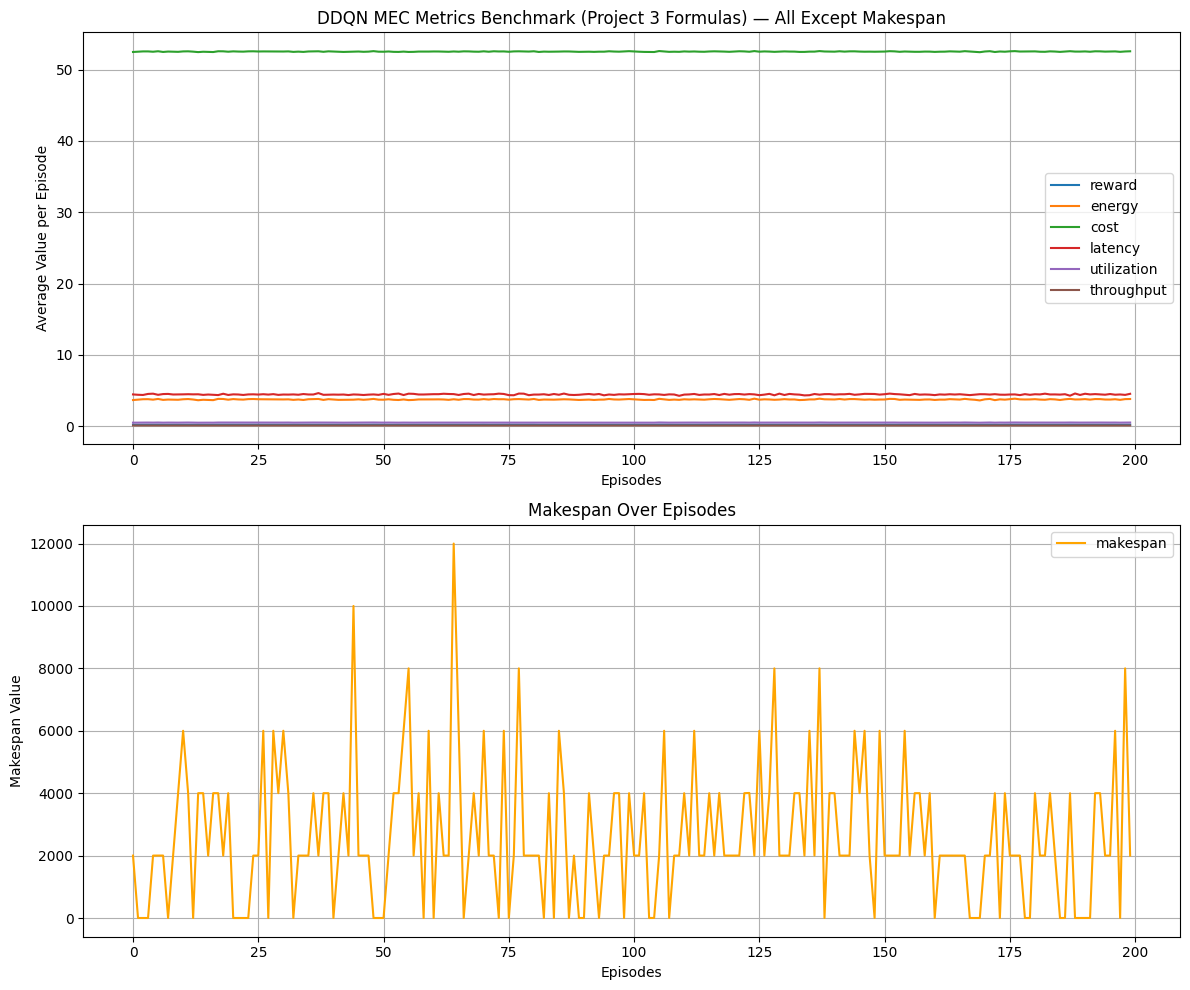

In [21]:
# 📌 Cell 9: Plotting Results (Separated Makespan)

metrics_dict = {k: [ep[k] for ep in all_metrics] for k in all_metrics[0]}

plt.figure(figsize=(12, 10))

# --- Subplot 1: All metrics except makespan ---
plt.subplot(2, 1, 1)
for k, v in metrics_dict.items():
    if k != 'makespan':  # Exclude makespan
        plt.plot(v, label=k)
plt.legend()
plt.title("DDQN MEC Metrics Benchmark (Project 3 Formulas) — All Except Makespan")
plt.xlabel("Episodes")
plt.ylabel("Average Value per Episode")
plt.grid(True)

# --- Subplot 2: Makespan only ---
plt.subplot(2, 1, 2)
plt.plot(metrics_dict['makespan'], color='orange', label='makespan')
plt.legend()
plt.title("Makespan Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Makespan Value")
plt.grid(True)

plt.tight_layout()
plt.show()


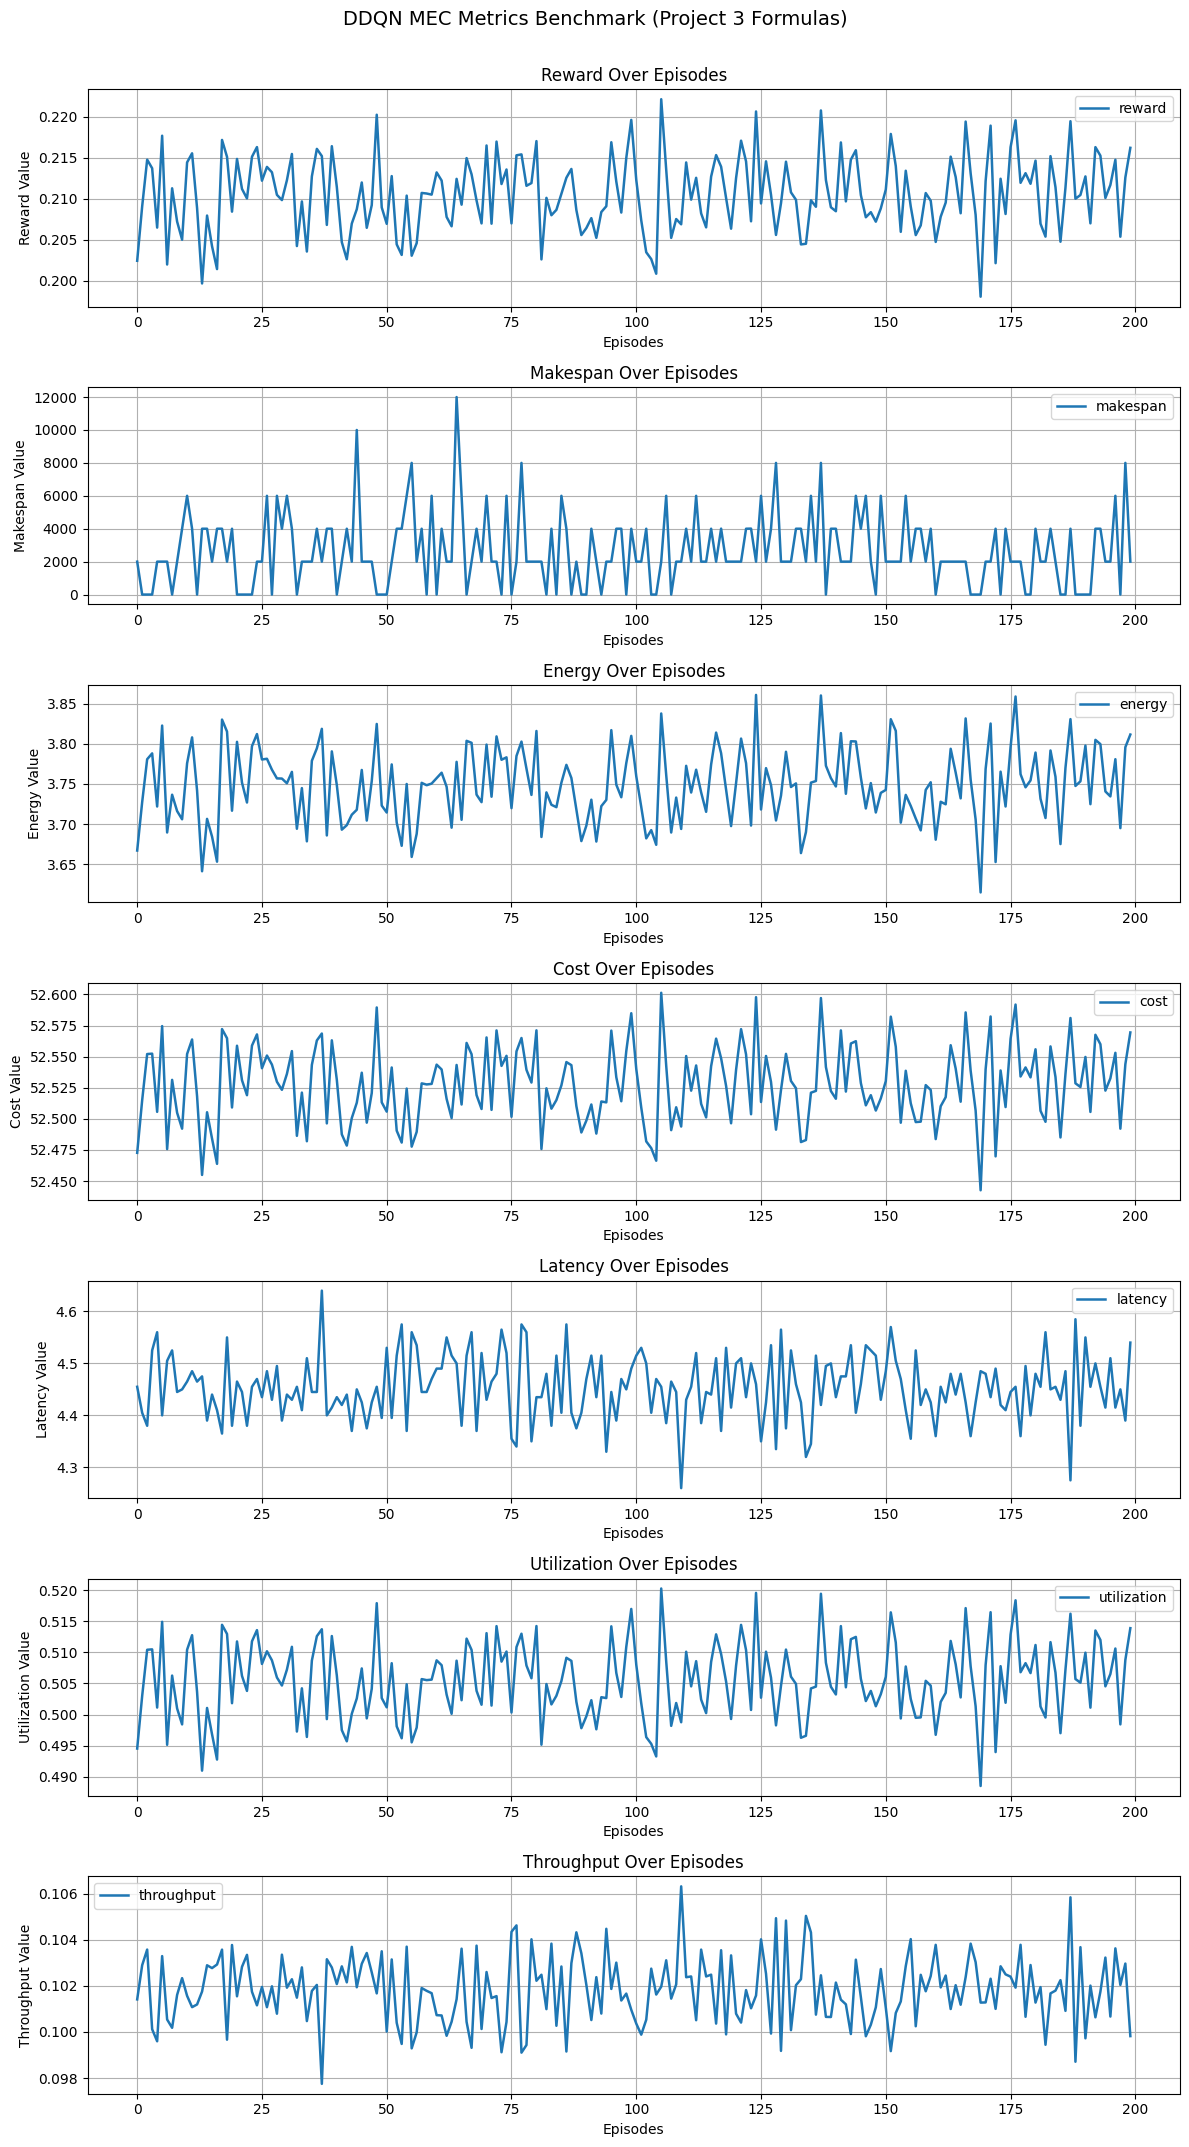

In [15]:
# 📌 Cell 9: Plotting Results (Each Metric in Separate Subplot)

metrics_dict = {k: [ep[k] for ep in all_metrics] for k in all_metrics[0]}
metric_names = list(metrics_dict.keys())
num_metrics = len(metric_names)

plt.figure(figsize=(12, 3 * num_metrics))  # Adjust height based on number of metrics

for i, k in enumerate(metric_names, 1):
    plt.subplot(num_metrics, 1, i)
    plt.plot(metrics_dict[k], label=k, linewidth=1.8)
    plt.legend()
    plt.title(f"{k.capitalize()} Over Episodes")
    plt.xlabel("Episodes")
    plt.ylabel(f"{k.capitalize()} Value")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("DDQN MEC Metrics Benchmark (Project 3 Formulas)", fontsize=14, y=1.02)
plt.show()


In [ ]:
# 📌 Cell 10: Testing Cell and CSV Output

def test_agent_with_summary(env, agent, episodes=10):
    # Note: Using agent.act(state, epsilon=0.0) for greedy exploitation
    results = []
    all_metrics = []
    
    for ep in range(episodes):
        state, _ = env.reset()
        ep_reward = 0.0
        ep_step_metrics = []
        done = False
        steps = 0
        
        # Run for the same number of steps as training episodes
        for _ in range(50):
            # Greedy action
            action = agent.act(state, epsilon=0.0)
            step_result = env.step(action)

            # Custom environment step returns 5 items: next_state, reward, done, info, metrics
            next_state, reward, done, _, metrics = step_result
            
            ep_reward += reward
            ep_step_metrics.append(metrics)
            state = next_state
            steps += 1
            if done:
                break
        
        # Aggregate step metrics for the episode
        agg_metrics = {k: np.mean([m.get(k, 0) for m in ep_step_metrics]) for k in ep_step_metrics[0].keys()}
        agg_metrics['total_reward'] = ep_reward
        results.append(agg_metrics)
        all_metrics.extend(ep_step_metrics)
    
    df_results = pd.DataFrame(results)
    
    # Calculate overall average metrics for the test
    mean_reward = df_results['total_reward'].mean()
    metrics_summary = {
        'total_reward': round(mean_reward, 4),
        'avg_latency': round(df_results['latency'].mean(), 4),
        'avg_energy': round(df_results['energy'].mean(), 4),
        'avg_cost': round(df_results['cost'].mean(), 4),
        'avg_throughput': round(df_results['throughput'].mean(), 4),
        'avg_utilization': round(df_results['utilization'].mean(), 4),
    }
    
    return mean_reward, metrics_summary

# --- Execution ---
print("Running test... (10 episodes)")

# 1. Load trained model
agent.load_model(MODEL_PATH)

# 2. Run testing
mean_reward, metrics_summary = test_agent_with_summary(env, agent, episodes=10)

print(f"Test Mean Reward: {mean_reward:.4f}")
print("Test Metrics Summary:")
print(metrics_summary)

# 3. Save summary to CSV (for comparison)
summary_df = pd.DataFrame.from_dict({'DDQN_Base_Model': metrics_summary}, orient='index')
summary_df.to_csv('base_model_results.csv')
print("\nTest summary saved to base_model_results.csv")


Running test... (10 episodes)
Test Mean Reward: 10.5411
Test Metrics Summary:
{'total_reward': np.float64(10.5411), 'avg_latency': np.float64(4.4715), 'avg_energy': np.float64(3.7457), 'avg_cost': np.float64(52.5288), 'avg_throughput': np.float64(0.1015), 'avg_utilization': np.float64(0.5058)}

Test summary saved to base_model_results.csv


In [18]:
### End of Notebook ###